### Imports

In [1]:
import sys
import numpy as np
sys.path.append('src')
from control.controller_decentralized import Decentralized
from control.controller_decentralized_RL import DecentralizedRL
from control.controller_centralized_RL import CentralizedRL
from agents.deep_policy_gradient import DeepPolicyGradient
from agents.policy_gradient import PolicyGradient
from agents.deep_q import DQN
from agents.agent import Agent
from agents.random_agent import RandomAgent
from environments.env_wrapper import EnvWrappper


### Environment Setup

In [2]:
def set_env(environment_name):
    print('Initializing environment...')

    if environment_name == 'taxi':
        sys.path.append('../environments/MultiTaxiEnv')
        from environments.MultiTaxiEnv.taxi_environment import TaxiEnv
        env = TaxiEnv(2)
        # Make sure it works with our API:
        env.agents = env.taxis_names
        env.action_spaces = {
            agent_name: env.action_space for agent_name in env.agents
        }
        env.observation_spaces = {
            agent_name: env.observation_space for agent_name in env.agents
        }
        env.possible_agents = [agent for agent in env.agents]
        needs_conv = False

    elif environment_name == 'cleanup':
        sys.path.append('../environments/cleanup')
        from environments.cleanup.social_dilemmas.envs.cleanup import CleanupEnv
        env = CleanupEnv(num_agents=5, render=True)
        env.action_spaces = {
            agent_name: env.action_space for agent_name in env.agents
        }
        env.observation_spaces = {
            agent_name: env.observation_space for agent_name in env.agents
        }
        env.possible_agents = [agent for agent in env.agents.keys()]
        needs_conv = True
        
    # Petting Zoo:
    elif environment_name == 'particle':
        from pettingzoo.mpe import simple_spread_v2
        env = simple_spread_v2.parallel_env(max_cycles=np.inf)
        needs_conv = False
        
    elif environment_name == 'piston':
        from pettingzoo.butterfly import pistonball_v4
        env = pistonball_v4.parallel_env(continuous=False)
        needs_conv = True
        
    else:
        print("Invalid Enviornment Name!")
        return
        
    return EnvWrappper(env, needs_conv=needs_conv)



#### Choose Environment
In the name variable enter one of the following options:
    - MultiTaxi = 'taxi'
    - Cleanup = 'cleanup'
    - Particle = 'particle'
    - PistonBall = 'piston'
    

In [3]:
###
name = "taxi"
environment = set_env(name)

Initializing environment...


## Decentralized


### Agents Setup

In [4]:
def create_decentralized_agent(policy_name, env):
    num_obs = env.get_num_obs()
    num_actions = env.get_num_actions()
    needs_conv = env.get_needs_conv()
    mapping_fn = lambda x: x.flatten() if not needs_conv else None
    
    if policy_name == 'pg':
        return Agent(PolicyGradient(num_actions, num_obs, mapping_fn=mapping_fn))
    
    elif policy_name == 'dpg':
        return Agent(DeepPolicyGradient(num_obs, num_actions, is_conv=needs_conv,
                                        mapping_fn=mapping_fn)) 
        
    elif policy_name == 'dqn':
        return Agent(DQN(num_obs, num_actions, is_conv=needs_conv,
                                        mapping_fn=mapping_fn)) 
        
    print("Invalid Policy!")       
    return


#### Choose Agents

In the policy variable enter one of the following options:
    - Policy Gradient = 'pg'
    - Deep Policy Gradient = 'dpg'
    - Deep Q-Network = 'dqn'



In [5]:
decentralized_policy = "pg"
env_agents = environment.get_env_agents()
decentralized_agents = {agent_name: create_decentralized_agent(decentralized_policy, environment)
          for agent_name in env_agents}

### Run Test

In [6]:
controller = DecentralizedRL(environment, decentralized_agents)
controller.run(render=True, max_iteration=10, max_episode_len=25, num_episodes=10, batch_size=0)

+---------+
|X: |F: :X|
| : | : : |
| :_: : : |
| | : | : |
|X| :G|X: |
+---------+
Taxi1-YELLOW: Fuel: 100, Location: (0,0), Collided: False
Taxi2-RED: Fuel: 100, Location: (2,1), Collided: False
Passenger1: Location: (4, 0), Destination: (0, 0)
Done: False, {'taxi_1': False, 'taxi_2': False, '__all__': False}
Passengers Status's: [2]
+---------+
|X: |F: :X|
|_: | : : |
| :_: : : |
| | : | : |
|X| :G|X: |
+---------+
  (south ,dropoff)
Taxi1-YELLOW: Fuel: 99, Location: (1,0), Collided: False
Taxi2-RED: Fuel: 100, Location: (2,1), Collided: False
Passenger1: Location: (4, 0), Destination: (0, 0)
Done: False, {'taxi_1': False, 'taxi_2': False, '__all__': False}
Passengers Status's: [2]
+---------+
|X: |F: :X|
|_: | : : |
| :_: : : |
| | : | : |
|X| :G|X: |
+---------+
  (pickup ,dropoff)
Taxi1-YELLOW: Fuel: 99, Location: (1,0), Collided: False
Taxi2-RED: Fuel: 100, Location: (2,1), Collided: False
Passenger1: Location: (4, 0), Destination: (0, 0)
Done: False, {'taxi_1': False, 'taxi_2':

## Centralized

### Agent Setup

In [7]:
def create_centralized_agent(policy_name, env):
    needs_conv = env.get_needs_conv()
    num_obs = env.get_num_obs() if needs_conv else\
        (1, env.get_num_obs()[::-1][0] * (len(env.get_env_agents())))
    num_actions = (env.get_num_actions()) ** (len(env.get_env_agents()))    
    mapping_fn = lambda x: x.flatten() if not needs_conv else None
    
    if policy_name == 'pg':
        return Agent(PolicyGradient(num_actions, num_obs, mapping_fn=mapping_fn))
    
    elif policy_name == 'dpg':
        return Agent(DeepPolicyGradient(num_obs, num_actions, is_conv=needs_conv,
                                        mapping_fn=mapping_fn)) 
        
    elif policy_name == 'dqn':
        return Agent(DQN(num_obs, num_actions, is_conv=needs_conv,
                                        mapping_fn=mapping_fn)) 
        
    print("Invalid Policy!")       
    return

#### Choose Central Agent

In the policy variable enter one of the following options:
    - Policy Gradient = 'pg'
    - Deep Policy Gradient = 'dpg'
    - Deep Q-Network = 'dqn'



In [8]:
centralized_policy = "pg"
decision_maker = create_centralized_agent(centralized_policy, environment)
env_agents = environment.get_env_agents()
centralized_agents = {agent_name: None  for agent_name in env_agents}

### Run Test

In [9]:
controller = CentralizedRL(environment, centralized_agents, decision_maker)
controller.run(render=True, max_iteration=10, max_episode_len=25, num_episodes=10, batch_size=0)


+---------+
|X: |F: :X|
| : |_: : |
| : : : : |
| | : | : |
|X| :G|X: |
+---------+
Taxi1-YELLOW: Fuel: 100, Location: (0,4), Collided: False
Taxi2-RED: Fuel: 100, Location: (1,2), Collided: False
Passenger1: Location: (0, 4), Destination: (4, 0)
Done: False, {'taxi_1': False, 'taxi_2': False, '__all__': False}
Passengers Status's: [2]
+---------+
|X: |F: :X|
| : |_: : |
| : : : : |
| | : | : |
|X| :G|X: |
+---------+
  (east ,refuel)
Taxi1-YELLOW: Fuel: 100, Location: (0,4), Collided: False
Taxi2-RED: Fuel: 100, Location: (1,2), Collided: False
Passenger1: Location: (0, 4), Destination: (4, 0)
Done: False, {'taxi_1': False, 'taxi_2': False, '__all__': False}
Passengers Status's: [2]
+---------+
|X: |F: :X|
| : |_: : |
| : : : : |
| | : | : |
|X| :G|X: |
+---------+
  (east ,refuel)
Taxi1-YELLOW: Fuel: 100, Location: (0,4), Collided: False
Taxi2-RED: Fuel: 100, Location: (1,2), Collided: False
Passenger1: Location: (0, 4), Destination: (4, 0)
Done: False, {'taxi_1': False, 'taxi_2': Fa

### Economic Control 

In [10]:
from control.controller_economic import EconomicControl
sys.path.append('environments/corners')
from environments.corners.corners_env import CornersEnv
from environments.corners.corners_agents import EconomicGoalAgent
env = CornersEnv()

tasks = [[0,0], [0, 4], [4, 0], [4, 4], [2,2]] # The goal position

In [11]:
agents = {agent: EconomicGoalAgent() for agent in env.agents}
controller = EconomicControl(env, agents, tasks)
controller.run(float('inf'))

Step 1:
╔═══════════╗
║         E ║
║     C     ║
║   A       ║
║       D   ║
║     B     ║
╚═══════════╝

Step 2:
╔═══════════╗
║         E ║
║   A       ║
║     C     ║
║           ║
║   B   D   ║
╚═══════════╝

Step 3:
╔═══════════╗
║         E ║
║ A         ║
║     C     ║
║           ║
║ B       D ║
╚═══════════╝

Step 4:
╔═══════════╗
║ A       E ║
║           ║
║     C     ║
║           ║
║ B       D ║
╚═══════════╝

Finished


### Random Agent

In [12]:
environment = set_env('taxi')

Initializing environment...


In [13]:
spaces = environment.get_env().action_spaces
agents = {
    agent_name: RandomAgent(spaces[agent_name])
    for agent_name in spaces
}
controller = Decentralized(environment, agents)
controller.run(True, 20)

+---------+
|X: |F: :X|
| : | :_: |
|_: : : : |
| | : | : |
|X| :G|X: |
+---------+
Taxi1-YELLOW: Fuel: 100, Location: (1,3), Collided: False
Taxi2-RED: Fuel: 100, Location: (2,0), Collided: False
Passenger1: Location: (4, 3), Destination: (4, 0)
Done: False, {'taxi_1': False, 'taxi_2': False, '__all__': False}
Passengers Status's: [2]
+---------+
|X: |F: :X|
| : | :_: |
|_: : : : |
| | : | : |
|X| :G|X: |
+---------+
  (pickup ,pickup)
Taxi1-YELLOW: Fuel: 100, Location: (1,3), Collided: False
Taxi2-RED: Fuel: 100, Location: (2,0), Collided: False
Passenger1: Location: (4, 3), Destination: (4, 0)
Done: False, {'taxi_1': False, 'taxi_2': False, '__all__': False}
Passengers Status's: [2]
+---------+
|X: |F:_:X|
| : | : : |
|_: : : : |
| | : | : |
|X| :G|X: |
+---------+
  (north ,pickup)
Taxi1-YELLOW: Fuel: 99, Location: (0,3), Collided: False
Taxi2-RED: Fuel: 100, Location: (2,0), Collided: False
Passenger1: Location: (4, 3), Destination: (4, 0)
Done: False, {'taxi_1': False, 'taxi_2': 

## Evaluating

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import evaluate

def plot_hist(sums, name):
    plt.hist(sums, rwidth=0.8)
    plt.xlabel('Episodic Reward Sum')
    plt.ylabel('Number of Episodes')
    plt.title(f'Rewards Histogram - {name}')
    print(f'Mean is {sum(sums)/len(sums)}')

### Random Agents

Mean is -228.19


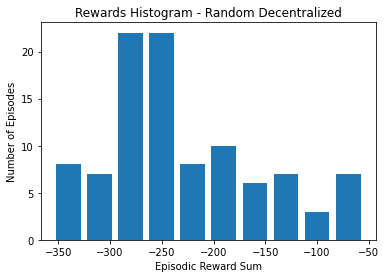

In [15]:
controller = evaluate.make_random_decentralized_control()
results = evaluate.evaluate_controller(controller, 100, RL=False)
sums = evaluate.sum_all_agents(results)
plot_hist(sums, 'Random Decentralized')

### Decentralied DPG

Starting training...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]src\agents\deep_policy_gradient.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.policy.forward(observation))
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.07it/s]
src\agents\deep_policy_gradient.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.policy.forward(observation))


Mean is -41.94


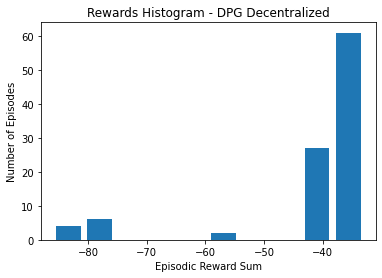

In [16]:
controller = evaluate.make_rl_decentralized_control('dpg')
controller.train(25, 1000)
results = evaluate.evaluate_controller(controller, 100, RL=True)
sums = evaluate.sum_all_agents(results)
plot_hist(sums, 'DPG Decentralized')

## Centralized DPG

Starting training...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.28it/s]


Mean is -294.8


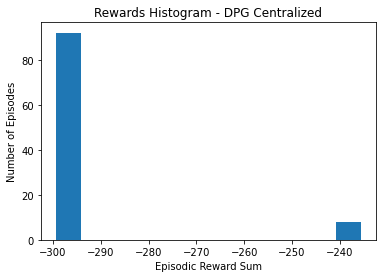

In [17]:
controller = evaluate.make_rl_centralized_control('dpg')
controller.train(25, 1000)
results = evaluate.evaluate_controller(controller, 100, RL=True)
sums = evaluate.sum_all_agents(results)
plot_hist(sums, 'DPG Centralized')